In [3]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pickle
from keras import layers
import keras
from tensorflow.keras import regularizers

In [3]:
# Define the path to the folder containing the dataset
# folder_path = '/content/BeefCattle_Muzzle_Individualized'
# file_list = os.listdir(folder_path)
# file_file_list = [os.listdir('/content/BeefCattle_Muzzle_Individualized/'+i) for i in file_list]
# test =[[cv2.resize(cv2.imread(os.path.join('/content/BeefCattle_Muzzle_Individualized/',file_list[i],j)),(224,224)).astype('float32')/255 for j in file_file_list[i]] for i in range(len(file_list))]

In [4]:
# for i in range(27):
#   with open('/content/drive/MyDrive/CowImagesSoCool/list-'+str(i+1)+'.pkl', "wb") as fl:
#     pickle.dump(test[i*10:(i+1)*10], fl)

In [24]:
# Print the sizes of training, validation, and testing datasets
print("Training data:",round(27*0.7))
print("Validation data:",round(27*0.15))
print("Testing data:",round(27*0.15))

Training data: 19
Validation data: 4
Testing data: 4


In [8]:
# Define lists to store training and validation datasets

train_dataset = []
val_dataset = []
for i in range(19):
  with open("/kaggle/input/cowmuzzle/list-"+str(i+1)+".pkl", "rb") as fl:
    train_dataset.extend(pickle.load(fl))
for i in range(19,23):
  with open("/kaggle/input/cowmuzzle/list-"+str(i+1)+".pkl", "rb") as fl:
    val_dataset.extend(pickle.load(fl))

In [ ]:
train_dataset[0][0].shape
val_dataset[0][0].shape

### Data Handling

In [11]:
### Data Handling

# Define a custom data generator class for creating batches during training and validation
class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self,x1,x2,y,batch_size,dataset) :
        self.x1 = x1
        self.x2 = x2
        self.y = y
        self.batch_size = batch_size
        self.dataset = dataset

    def __len__(self) :
        # Calculate the number of batches per epoch
        return (np.ceil(len(self.x1) / float(self.batch_size))).astype(int)
    
    def __getitem__(self, idx) :
        batch_x1 = self.x1[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_x2 = self.x2[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx+1) * self.batch_size]
        return (np.array([(self.dataset[cow][cow_index]) for cow,cow_index in batch_x1]),np.array([(self.dataset[cow][cow_index]) for cow,cow_index in batch_x2])), np.array(batch_y)

In [12]:
# Define the size of training and validation datasets
train_size = 70000
val_size = 15000

In [13]:
def get_dataset(n,dataset1):
  mid = n//2
  data_index = [i for i in range(len(dataset1))]
  cow1_index = []
  cow2_index = []
  label = []
  for i in range(mid):
    '''
      Create pairs of similar and dissimilar images for training or validation
      n: size of the dataset
      dataset1: the dataset to create pairs from
      Return indices of images and their labels
      Format: (x1_index, x2_index, label)
      x1_index: index of the first image
      x2_index: index of the second image
      label: 0 for similar, 1 for dissimilar
    '''
    u_cow1,u_cow2 = random.sample(data_index, 2)
    temp_cow1 = [i for i in range(len(dataset1[u_cow1]))]
    temp_cow2 = [i for i in range(len(dataset1[u_cow2]))]
    anc,po = random.sample(temp_cow1,2)
    ne = random.choice(temp_cow2)
    cow1_index.append([u_cow1,anc])
    cow2_index.append([u_cow1,po])
    label.append(0)
    cow1_index.append([u_cow1,anc])
    cow2_index.append([u_cow2,ne])
    label.append(1)
  temp = list(zip(cow1_index,cow2_index,label))
  random.shuffle(temp)
  print(len(temp))
  print(temp[3])
  x1 = []
  x2 = []
  y = []
  for cow1,cow2,label in temp:
    x1.append(cow1)
    x2.append(cow2)
    y.append(label)
  del temp
  return x1,x2,y

In [14]:
# Split the dataset into training and validation sets
siam_dataset_train = get_dataset(train_size,train_dataset)
siam_dataset_val = get_dataset(val_size,val_dataset)

70000
([170, 5], [77, 19], 1)
15000
([18, 3], [0, 3], 1)


In [15]:
# Extract indices and labels from the dataset
X1_train_index,X2_train_index,y_train = siam_dataset_train[0],siam_dataset_train[1],siam_dataset_train[2]
X1_val_index,X2_val_index,y_val = siam_dataset_val[0],siam_dataset_val[1],siam_dataset_val[2]

In [16]:
def cosine_similarity(tensors):
    normalized_tensor1 = tf.nn.l2_normalize(tensors[0], axis=1)
    normalized_tensor2 = tf.nn.l2_normalize(tensors[1], axis=1)
    similarity = tf.reduce_sum(tf.multiply(normalized_tensor1, normalized_tensor2), axis=1)
    return tf.expand_dims(similarity, axis=-1)

### Encoder: Convolutional layers

In [17]:
### Model Definition

# Define a Siamese neural network model using Keras
# The model consists of an encoder part followed by a cosine similarity layer and a classification layer
# The encoder part consists of convolutional layers followed by fully connected layers
# The model takes two input images, processes them through the encoder, and outputs a binary classification result

strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
#-----------ENCODER PART------------------
    reg_strength=0.0001
    Encoder = keras.Sequential(name='imageEncoder')
    Encoder.add(layers.Input(shape=(224,224,3)))
    Encoder.add(layers.Conv2D(64, (10,10),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(64, (10,10),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(64, (10,10),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(64, (10,10),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(128, (7,7),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(128, (7,7),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(128, (7,7),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(128, (7,7),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(256, (3,3),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(256, (3,3),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Conv2D(256, (3,3),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),kernel_regularizer=regularizers.l2(reg_strength)))
    # Encoder.add(layers.Conv2D(256, (3,3),padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.MaxPooling2D())
    Encoder.add(layers.SpatialDropout2D(rate=0.3))

    Encoder.add(layers.Flatten())
    Encoder.add(layers.Dense(1000))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())
    Encoder.add(layers.Dropout(0.2))
    Encoder.add(layers.Dense(500))
    Encoder.add(layers.BatchNormalization())
    Encoder.add(layers.ELU())

    image_1 = layers.Input(shape=(224, 224, 3), name='imageInput1')
    image_2 = layers.Input(shape=(224, 224, 3), name='imageInput2')
    encoded_rep_1 = Encoder(image_1)
    encoded_rep_2 = Encoder(image_2)
    distance = layers.Lambda(cosine_similarity, name='cosineSimilarityMetric')([encoded_rep_1, encoded_rep_2])
    output = layers.Dense(2, activation='softmax',name='siameseOutput')(distance)
    siamese_model = keras.Model(inputs=[image_1, image_2], outputs=[output],name="cowMuzzleSiameseModel")
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=["accuracy"])


Number of devices: 2


In [18]:
siamese_model.summary()

Model: "cowMuzzleSiameseModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 imageInput1 (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 imageInput2 (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 imageEncoder (Sequential)   (None, 500)                  5333740   ['imageInput1[0][0]',         
                                                                     'imageInput2[0][0]']         
                                                                                                  
 cosineSimilarityMetric (La  (None, 1)                    0         ['imageEnc

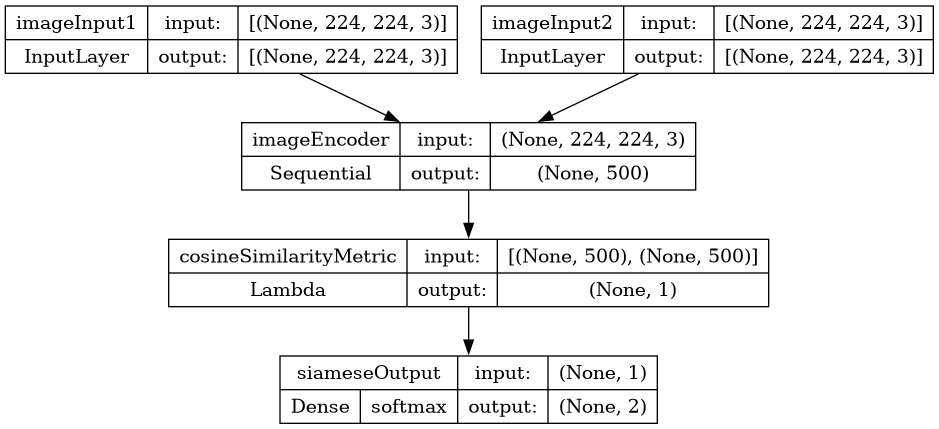

In [19]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(siamese_model, to_file=dot_img_file, show_shapes=True, show_layer_activations=True)

In [20]:
### Training
# Define batch size
batch_size = 64
my_training_batch_generator = My_Custom_Generator(X1_train_index,X2_train_index,y_train, batch_size,train_dataset)
my_validation_batch_generator = My_Custom_Generator(X1_val_index,X2_val_index,y_val, batch_size,val_dataset)

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience = 3,
                                              verbose=1,
                                              )
checkpoint = tf.keras.callbacks.ModelCheckpoint("cowMuzzleSiameseModel", monitor="val_loss", save_best_only=True, verbose=1)

In [22]:
History=siamese_model.fit(x=my_training_batch_generator,
                   steps_per_epoch = int(len(X1_train_index) //(batch_size)),
                   epochs = 15,
                   verbose = 1,
                   callbacks=[early_stop,checkpoint],
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(len(X1_val_index)// (batch_size)))

Epoch 1/15


2024-03-16 08:44:45.631591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incowMuzzleSiameseModel/imageEncoder/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1710578715.178916     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1093/1093 [==============================] - ETA: 0s - loss: 122.5873 - accuracy: 0.8123
Epoch 1: val_loss improved from inf to 47.94476, saving model to cowMuzzleSiameseModel
1093/1093 [==============================] - 870s 757ms/step - loss: 122.5873 - accuracy: 0.8123 - val_loss: 47.9448 - val_accuracy: 0.8378
Epoch 2/15
1093/1093 [==============================] - ETA: 0s - loss: 23.2143 - accuracy: 0.8982
Epoch 2: val_loss improved from 47.94476 to 8.89163, saving model to cowMuzzleSiameseModel
1093/1093 [==============================] - 809s 740ms/step - loss: 23.2143 - accuracy: 0.8982 - val_loss: 8.8916 - val_accuracy: 0.8606
Epoch 3/15
1093/1093 [==============================] - ETA: 0s - loss: 4.2459 - accuracy: 0.9249
Epoch 3: val_loss improved from 8.89163 to 1.69803, saving model to cowMuzzleSiameseModel
1093/1093 [==============================] - 808s 739ms/step - loss: 4.2459 - accuracy: 0.9249 - val_loss: 1.6980 - val_accuracy: 0.9025
Epoch 4/15
1093/1093 [=========

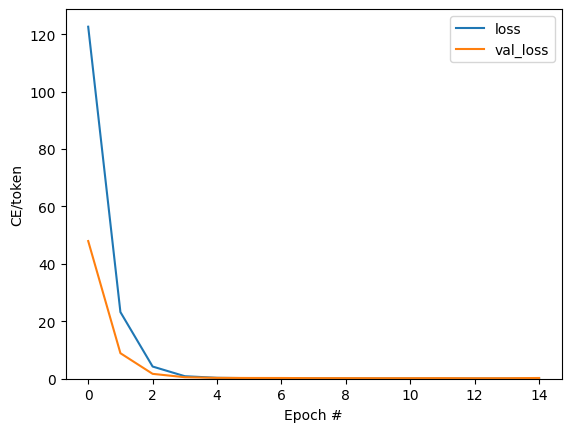

In [23]:
plt.plot(History.history['loss'], label='loss')
plt.plot(History.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

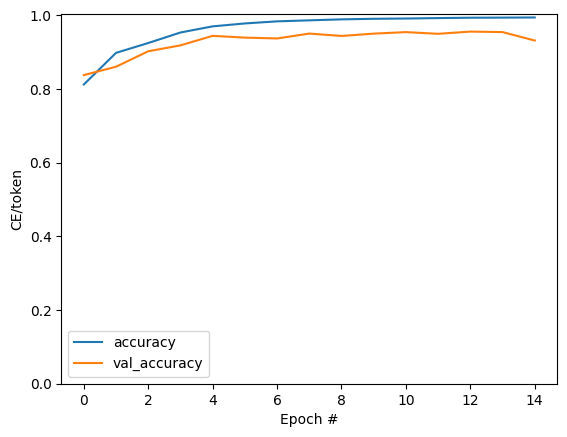

In [25]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [26]:
loaded_model = keras.models.load_model('cowMuzzleSiameseModel',safe_mode=False)

In [27]:
test_dataset = []
for i in range(23,27):
  with open("/kaggle/input/cowmuzzle/list-"+str(i+1)+".pkl", "rb") as fl:
    test_dataset.extend(pickle.load(fl))

In [28]:
test_dataset[0][0].shape

(224, 224, 3)

In [35]:
test_siamese_dataset = get_dataset(n=15000,dataset1=test_dataset)

15000
([11, 1], [8, 9], 1)


In [36]:
test_siamese_yactual=test_siamese_dataset[2]

In [37]:
my_test_batch_generator=My_Custom_Generator(test_siamese_dataset[0],test_siamese_dataset[1],test_siamese_dataset[2], 64,test_dataset)

In [38]:
len(my_test_batch_generator)

235

In [40]:
test_siamese_ypred_keras = loaded_model.predict(my_test_batch_generator)

235/235 [==============================] - 52s 220ms/step


In [70]:
# test_siamese_ypred = [0 if i[0]>0.95 else 1 for i in test_siamese_ypred_keras]

In [78]:
test_siamese_ypred = [0 if i[0]>i[1] else 1 for i in test_siamese_ypred_keras]

In [79]:
len(test_siamese_yactual)

15000

In [80]:
len(test_siamese_ypred)

15000

In [81]:
from sklearn.metrics import roc_curve, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_siamese_yactual,test_siamese_ypred)
auc_keras = auc(fpr_keras, tpr_keras)

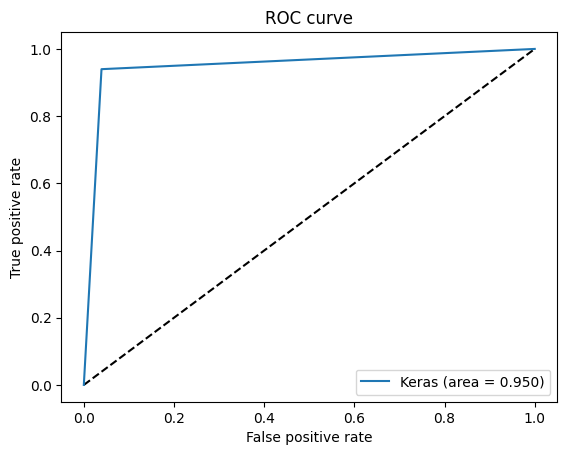

In [82]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [83]:
loaded_model.summary()

Model: "cowMuzzleSiameseModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 imageInput1 (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 imageInput2 (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 imageEncoder (Sequential)   (None, 500)                  5333740   ['imageInput1[0][0]',         
                                                                     'imageInput2[0][0]']         
                                                                                                  
 cosineSimilarityMetric (La  (None, 1)                    0         ['imageEnc

In [84]:
from sklearn.metrics import classification_report
print(classification_report(test_siamese_yactual , test_siamese_ypred,target_names=['similar','dissimilar']))

              precision    recall  f1-score   support

     similar       0.94      0.96      0.95      7500
  dissimilar       0.96      0.94      0.95      7500

    accuracy                           0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000



In [49]:
encoder = keras.Model(inputs=siamese_model.layers[2].input, outputs=siamese_model.layers[2].output)

In [56]:
similar = siamese_model.predict([np.array([train_dataset[10][0]]),np.array([train_dataset[0][2]])])

1/1 [==============================] - 0s 164ms/step


In [57]:
similar

array([[5.0152984e-04, 9.9949849e-01]], dtype=float32)

In [54]:
from numpy.linalg import norm
cosine = np.dot(similar[0],simailar[1])/(norm(similar[0])*norm(train_dataset[0][2]))
print("Cosine Similarity:", cosine)

ValueError: shapes (224,224,3) and (224,224,3) not aligned: 3 (dim 2) != 224 (dim 1)

In [ ]:
tf.keras.metrics.CosineSimilarity()(one,two).numpy()

In [ ]:
cosine_similarity([one,two])

In [ ]:
siamese_model.layers[4].get_weights()

In [ ]:
np.save('/content/drive/MyDrive/projectEvaluation500_history.npy',History.history)

In [ ]:
np.load('/content/drive/MyDrive/projectEvaluation500_history.npy',allow_pickle='TRUE').item()

In [ ]:
import time

# Start timer
start_time = time.perf_counter()

# Code to be timed
np.dot(one[0],two[0])/(norm(one[0])*norm(two[0]))


# End timer
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = (end_time - start_time+0.035)
print("Elapsed time: ", elapsed_time,"s")

In [ ]:
#1 cr cows in
print("Calculated time for 1cr cows : ", elapsed_time*10000000/60/60/60, "hrs")

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/siamesemodelsoftmax500',safe_mode=False)

In [ ]:
loaded_model.predict([np.array([dataset[0][0]]),np.array([dataset[0][3]])])

In [ ]:
siamese_model.save('cowMuzzleSiameseModel')